In [1]:
import sys
sys.path.append('..')

import os
import numpy as np
import matplotlib.pyplot as plt
import skimage.transform
from PIL import Image
import random

import torch
from torch import nn

from datasets.ice import IceWithProposals
from models.basic_pga.basic_pga_parts import PropAttention
from models.axial_unet.axial_attention import AxialAttention
from models.basic_pga.utils import get_image_dicts, build_pos_tensors

def conv1x1(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

# def build_pos_tensors(x, obj_dict, inds):
#     obj_inds = np.array(list(obj_dict.values()))[inds]
#     return x[obj_inds]

def build_pos_tensors(x, obj_dict, inds):
    obj_inds = np.array(list(obj_dict.values()))[inds]
    return x[:, obj_inds]

def build_rand_inds(heads, img_crop):
    rand_inds = []
    for _ in range(heads):
        inds_head = []
        for _ in range(img_crop):
            inds_head.append(random.sample(range(img_crop ** 2), img_crop))
        rand_inds.append(inds_head)
    return rand_inds

def add_vec_to_tensor(t, inds, vec, obj_dict):
    for i, v in zip(inds, vec):
        obj_ind = obj_dict[i]
        x = obj_ind // img_crop
        y = obj_ind % img_crop
        t[:,:,x,y] = v
    return t

def construct(t, img_crop, obj_dict, bg_dict, inds):
    img_flat = t.view(-1, img_crop**2)

    obj_vecs = []
    bg_vecs = []
    num_obj = img_crop // 2
    num_bg = img_crop - num_obj
    for i in range(num_obj):
        obj_vecs.append(build_pos_tensors(img_flat, obj_dict, inds[i]))
    for i in range(num_bg):
        bg_vecs.append(build_pos_tensors(img_flat, bg_dict, inds[i+num_obj]))

    obj_tensor = torch.stack(obj_vecs, dim=0)
    bg_tensor = torch.stack(bg_vecs, dim=0)

    all_tensor = torch.cat((obj_tensor, bg_tensor), dim=0)
    
    return all_tensor

def destruct(t, img, img_crop, obj_dict, bg_dict, inds):
    ts = torch.chunk(t, 2, dim=0)

    obj_tensor_tuple = torch.chunk(ts[0], ts[0].shape[0], dim=0)
    bg_tensor_tuple = torch.chunk(ts[1], ts[1].shape[0], dim=0)

    for i, vec in enumerate(obj_tensor_tuple):
        img = add_vec_to_tensor(img, inds[i], vec.squeeze(0).transpose(1,0), obj_dict)
#     for i, vec in enumerate(bg_tensor_tuple):
#         img = add_vec_to_tensor(img, inds[i+len(obj_tensor_tuple)], vec.squeeze(0).transpose(1,0), bg_dict)
    
    return img

In [2]:
data_dir = '../data'
img_scale = .3
img_crop = 220
heads = 2

train_set = IceWithProposals(os.path.join(data_dir, 'imgs'), os.path.join(data_dir, 'masks'),
                  os.path.join(data_dir, 'txt_files'), os.path.join(data_dir, 'proposals/binary_250_16'), 'train', img_scale, img_crop)

conv1 = conv1x1(3, 20)
prop = train_set[0]['prop'].unsqueeze(0)
img = train_set[0]['image'].unsqueeze(0)
img = conv1(img)
print(img.shape)

prop_flat = prop.flatten()
obj_dict, bg_dict = get_image_dicts(prop_flat)

rand_inds = build_rand_inds(heads, img_crop)

torch.Size([1, 20, 220, 220])


In [3]:
img_heads = torch.chunk(img, heads, dim=1)
img_heads[0].shape

torch.Size([1, 10, 220, 220])

In [4]:
head_list = []
for inds, h in zip(rand_inds, img_heads):
    head_list.append(construct(h, img_crop, obj_dict, bg_dict, inds))

In [5]:
t_out = torch.cat(head_list, dim=0)
print(t_out.shape)

torch.Size([440, 10, 220])


In [6]:
t_out = t_out.view(heads*img_crop, img_crop, -1)
print(t_out.shape)

torch.Size([440, 220, 10])


In [7]:
t_out = t_out*1.01

In [8]:
t_out = t_out.view(heads*img_crop, -1, img_crop)

In [9]:
ts = torch.chunk(t_out, heads, dim=0)

In [10]:
new_img_list = []
for t, img_head, inds in zip(ts, img_heads, rand_inds):
    new_img_list.append(destruct(t, img_head, img_crop, obj_dict, bg_dict, inds))
img_new = torch.cat(new_img_list, dim=1)

torch.Size([1, 20, 220, 220])


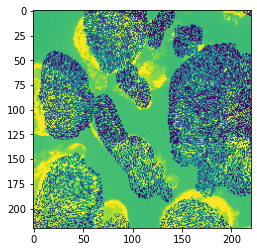

In [11]:
print(img_new.shape)
plt.imshow(img_new.squeeze(0).permute(1,2,0).detach().cpu().numpy()[:,:,12]);

torch.Size([1, 20, 220, 220]) torch.Size([1, 1, 220, 220])
torch.Size([220, 20, 220])
torch.Size([1, 20, 220]) torch.Size([1, 20, 220])


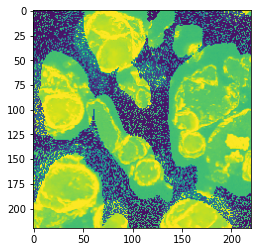

In [7]:
data_dir = '../data'
img_scale = .3
img_crop = 220
heads = 2

train_set = IceWithProposals(os.path.join(data_dir, 'imgs'), os.path.join(data_dir, 'masks'),
                  os.path.join(data_dir, 'txt_files'), os.path.join(data_dir, 'proposals/binary_250_16'), 'train', img_scale, img_crop)

conv1 = conv1x1(3, 20)
prop = train_set[0]['prop'].unsqueeze(0)
img = train_set[0]['image'].unsqueeze(0)
img = conv1(img)
print(img.shape, prop.shape)

prop_flat = prop.flatten()
obj_dict, bg_dict = get_image_dicts(prop_flat)

rand_inds = []
for _ in range(heads):
    inds_head = []
    for _ in range(img_crop):
        inds_head.append(random.sample(range(img_crop ** 2), img_crop))
    rand_inds.append(inds_head)
    
img_flat = img.view(-1, img_crop**2)

obj_vecs = []
bg_vecs = []
num_obj = img_crop // 2
num_bg = img_crop - num_obj
for i in range(num_obj):
    obj_vecs.append(build_pos_tensors(img_flat, obj_dict, rand_inds[0][i]))
for i in range(num_bg):
    bg_vecs.append(build_pos_tensors(img_flat, bg_dict, rand_inds[0][i+num_obj]))

obj_tensor = torch.stack(obj_vecs, dim=0)
bg_tensor = torch.stack(bg_vecs, dim=0)

obj_tensor = obj_tensor * 1.01
bg_tensor = bg_tensor * 1.01

all_tensor = torch.cat((obj_tensor, bg_tensor), dim=0)
print(all_tensor.shape)
obj_tensor_tuple = torch.chunk(obj_tensor, obj_tensor.shape[0], dim=0)
bg_tensor_tuple = torch.chunk(bg_tensor, bg_tensor.shape[0], dim=0)
print(obj_tensor_tuple[0].shape, obj_tensor_tuple[1].shape)

img_new = img_flat.view(1, -1, img_crop, img_crop)

def add_vec_to_tensor(t, inds, vec, obj_dict):
    for i, v in zip(inds, vec):
        obj_ind = obj_dict[i]
        x = obj_ind // img_crop
        y = obj_ind % img_crop
        t[:,:,x,y] = v
    return t

# for i, vec in enumerate(obj_tensor_tuple):
#     img_new = add_vec_to_tensor(img_new, rand_inds[0][i], vec.squeeze(0).transpose(1,0), obj_dict)
for i, vec in enumerate(bg_tensor_tuple):
    img_new = add_vec_to_tensor(img_new, rand_inds[0][i+num_obj], vec.squeeze(0).transpose(1,0), bg_dict)
    
# for i, v in zip(rand_inds[0][0], obj_vec.transpose(1,0)):
#     obj_ind = obj_dict[i]
#     x = obj_ind // img_crop
#     y = obj_ind % img_crop
#     img_new[:,:,x,y] = v
    
plt.imshow(img_new.squeeze(0).permute(1,2,0).detach().cpu().numpy()[:,:,0]);

In [9]:
all_tensor.shape

torch.Size([220, 20, 220])

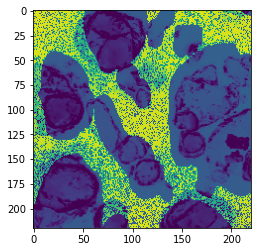

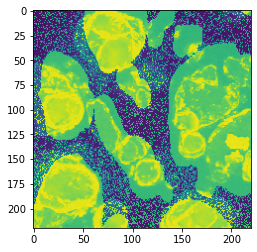

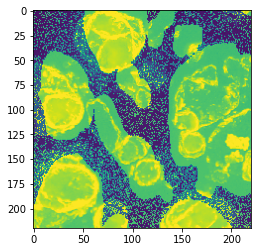

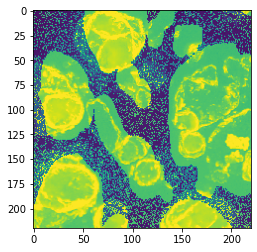

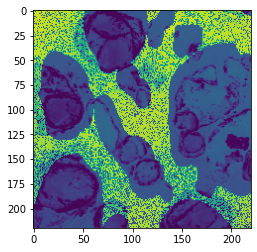

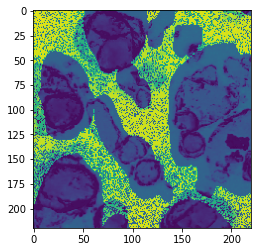

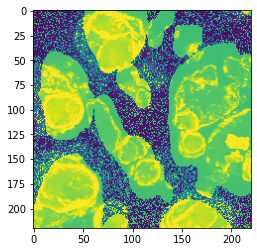

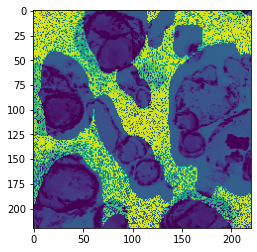

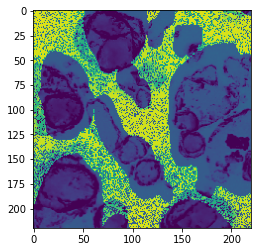

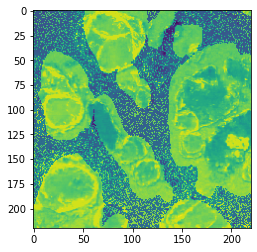

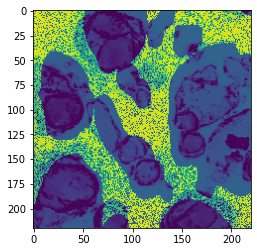

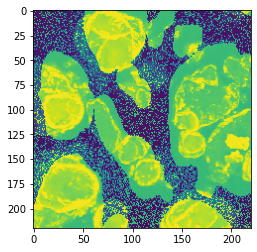

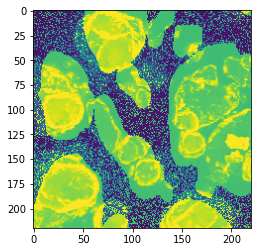

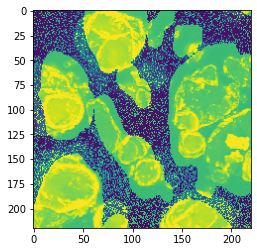

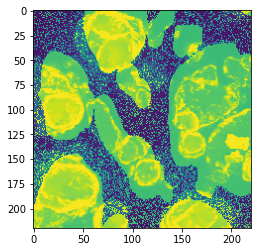

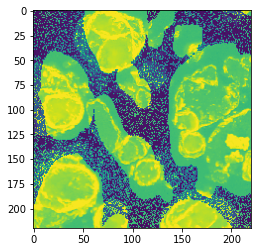

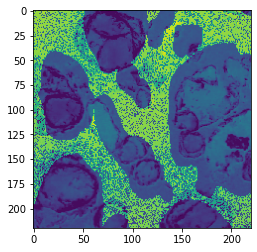

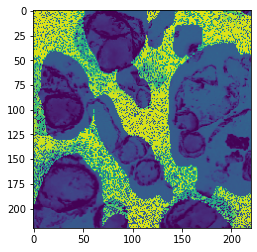

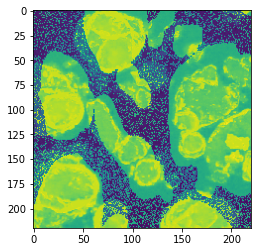

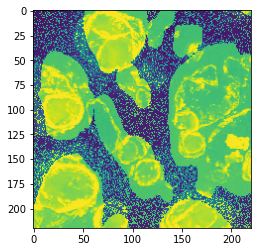

In [10]:
for i in range(20):
    plt.figure()
    plt.imshow(img_new.squeeze(0).permute(1,2,0).detach().cpu().numpy()[:,:,i]);

In [2]:
data_dir = '../data'
img_scale = .3
img_crop = 220
heads = 2

train_set = IceWithProposals(os.path.join(data_dir, 'imgs'), os.path.join(data_dir, 'masks'),
                  os.path.join(data_dir, 'txt_files'), os.path.join(data_dir, 'proposals/binary_250_16'), 'train', img_scale, img_crop)

In [3]:
conv1 = conv1x1(3, 20)
prop = train_set[0]['prop'].unsqueeze(0)
img = train_set[0]['image'].unsqueeze(0)
img = conv1(img)
print(img.shape, prop.shape)

torch.Size([1, 20, 220, 220]) torch.Size([1, 1, 220, 220])


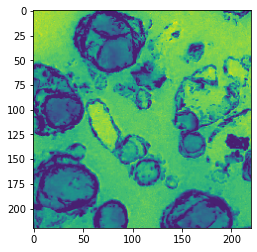

In [4]:
plt.imshow(img.squeeze(0).permute(1,2,0).detach().cpu().numpy()[:,:,0]);

In [5]:
prop_flat = prop.flatten()
obj_dict, bg_dict = get_image_dicts(prop_flat)

In [6]:
rand_inds = []
for _ in range(heads):
    inds_head = []
    for _ in range(img_crop):
        inds_head.append(random.sample(range(img_crop ** 2), img_crop))
    rand_inds.append(inds_head)

In [7]:
# img_flat = img.view(img_crop**2, -1)
img_flat = img.view(-1, img_crop**2)
print(img_flat.shape)

torch.Size([20, 48400])


In [8]:
# get obj vectors
obj_vecs = []
obj_vec = build_pos_tensors(img_flat, obj_dict, rand_inds[0][0])

In [9]:
# obj_vec = obj_vec *0 + 10
# obj_vec = obj_vec + 1

In [10]:
# obj_vec.shape

In [11]:
# v = obj_vec[0]
# i = rand_inds[0][0][0]
# obj_ind = obj_dict[i]
# print(i, v, obj_ind)

In [12]:
# tmp = img_flat[obj_ind] * 10
# print(tmp)

In [13]:
obj_vec = obj_vec * 1.01

In [14]:
img_new = img_flat.view(1, -1, img_crop, img_crop)

torch.Size([1, 20, 220, 220])


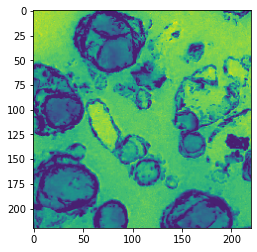

In [15]:
print(img_new.shape)
plt.imshow(img_new.squeeze(0).permute(1,2,0).detach().cpu().numpy()[:,:,0]);

In [16]:
# ex1 = torch.arange(0,img_crop**2)
# ex2 = torch.arange(1,img_crop**2+1)
# ex3 = torch.arange(2,img_crop**2+2)
# ex4 = torch.stack([ex1, ex2, ex3], dim=-1)
# ex5 = ex4.view(1, -1, img_crop, img_crop)
# ex5

In [17]:
# i = 222
# x = i // img_crop
# y = i % img_crop
# print(x,y)
# ex2[:,:,x,y]

In [18]:
for i, v in zip(rand_inds[0][0], obj_vec.transpose(1,0)):
    obj_ind = obj_dict[i]
    x = obj_ind // img_crop
    y = obj_ind % img_crop
#     print(prop[:,:,x,y])
#     print('v: ', v)
#     print('img_flat: ', img_flat[:,obj_ind])
#     print('img: ', img_new[:,:,x,y])
    img_new[:,:,x,y] = v

In [19]:
# i = rand_inds[0][0][0]
# v = obj_vec[0]
# obj_ind = obj_dict[i]
# img_flat[obj_ind, :] = v

In [20]:
# i = rand_inds[0][0][1]
# v = obj_vec[1]
# obj_ind = obj_dict[i]
# img_flat[obj_ind, :] = v

In [21]:
# for j in range(2):
#     i = rand_inds[0][0][j]
#     v = obj_vec[j]
#     obj_ind = obj_dict[i]
#     img_flat[obj_ind, :] = v

In [22]:
# img_flat[obj_ind,:] = tmp

In [23]:
# obj_vec[0]

In [24]:
# img_flat

In [25]:
img_new.shape

torch.Size([1, 20, 220, 220])

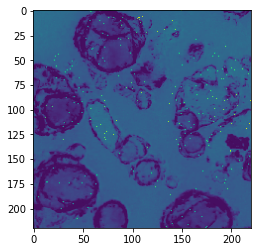

In [26]:
plt.imshow(img_new.squeeze(0).permute(1,2,0).detach().cpu().numpy()[:,:,0]);

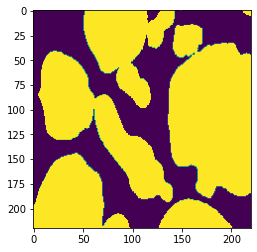

In [23]:
plt.imshow(prop.squeeze(0).squeeze(0).detach().cpu().numpy());

In [28]:
img_flat_copy.min()

tensor(-44.9851, grad_fn=<MinBackward1>)

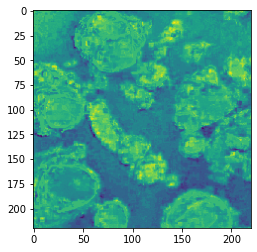

In [9]:
plt.imshow(img.squeeze(0).permute(1,2,0).detach().cpu().numpy()[:,:,1]);

In [56]:
i = 3257
x = i // img_crop
y = i % img_crop
dog = img.clone().detach()
v = img[:,:,x,y] * 1.01
dog[:,:,x,y] = v

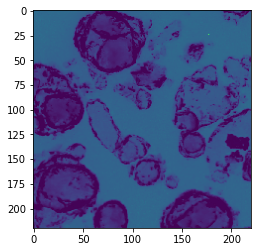

In [57]:
plt.imshow(dog.squeeze(0).permute(1,2,0).detach().cpu().numpy()[:,:,19]);

In [31]:
dog.mean()

tensor(0.2999, grad_fn=<MeanBackward0>)

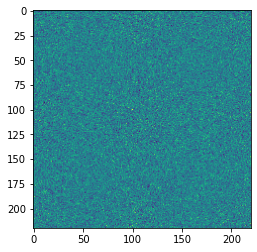

In [27]:
plt.imshow(dog.squeeze(0).permute(1,2,0).contiguous().detach().cpu().numpy()[:,:,2]);

In [12]:
img = torch.randn(1,20,220,220)

In [21]:
dog = img_flat.view(1, -1, img_crop, img_crop)
print(dog.shape)

torch.Size([1, 20, 220, 220])


In [15]:
v = v*0+5
print(v)
print(v.shape)

tensor([5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
        5., 5.], grad_fn=<AddBackward0>)
torch.Size([20])


In [16]:
v = v.unsqueeze(0)
print(v.shape)

torch.Size([1, 20])


In [25]:
dog[:,:,100,100] = v

In [5]:
img.shape

torch.Size([1, 20, 220, 220])

In [4]:
# v = torch.randn(3)
v = img[:,:,100,100] +0.1

In [5]:
print(v.max(), v.min())
print(img.max(), img.min())

tensor(1.9324, grad_fn=<MaxBackward1>) tensor(-1.6070, grad_fn=<MinBackward1>)
tensor(1.8344, grad_fn=<MaxBackward1>) tensor(-1.7091, grad_fn=<MinBackward1>)


In [6]:
img[:,:,100,100] = v

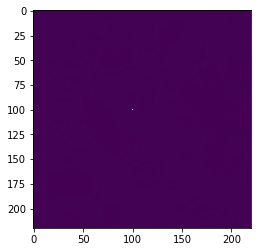

In [7]:
plt.imshow(img.squeeze(0).permute(1,2,0).detach().cpu().numpy()[:,:,0]);

In [32]:
img.squeeze(0).permute(1,2,0).detach().cpu().numpy()[:,:,0].max()

-2.0458512

In [33]:
img[:,:,100,100]

tensor([[-2.0553, -2.0671, -2.0656]])